# Characterizing the Labelling of Cre lines Based on Cortical Depth


# Team Member Names & Contributions

- **Taylor Wyrick** (A12089884): Discussion, Results, Abstract, Research Question, Hypothesis
- **Alexis Franklin** (A14456318): Introduction, Abstract, Background, Research Question, Hypothesis, Editing Code and Markdown Cells
- **Harpreet Setia** (A14731093): Data Wrangling, Data Analysis, Research Question, Hypothesis

# Abstract

# Research Question

1. Do the shared Cre lines between the Allen Brain Institute Cell Types and Brain Observatory databases label the same layers in the primary visual cortex?
  
  
2. Do the six different layers cluster by the various cell features provided by the Cell Types or Brain Observatory databases?


# Background and Prior Work


### References (include links):
(1) Cajal Santiago Ramón y. (1899). Textura del sistema nervioso del hombre y de los vertebrados. Madrid: Impr. y Libr. de Nicolás Moya.

(2) Sundberg, Sofie Charlotte, et al. (2017). “Cre-Expressing Neurons in Visual Cortex of Ntsr1-Cre GN220 Mice Are Corticothalamic and Are Depolarized by Acetylcholine.” Journal of Comparative Neurology, vol. 526, no. 1, pp. 120–132., doi:10.1002/cne.24323

# Hypothesis


1. We hypothesize each Cre-line that is shared between the two databases, the Allen Brain Cell Types and Brain Observatory, will label a specific cortical layer in the primary visual cortex.

    1. Since the labelling of the Cre-lines have already been characterized, we believe the results of our cortical depth should compare to the layers defined in the literature.
    2. Also based on the literature, there should be a few Cre-lines that are not specific to a cortical layer, and instead consist of scattered expression throughout the cortex.
   

2. We hypothesize the data will not cluster into six distinct clusters for each layer, but we do predict the data for Layer 4 will cluster together.

    1. Layer 4 exists as a distinct layer, compared to the other layers of cortex, because it is the primary input layer. Therefore, we believe the distinct cell features of this layer will cause the data for Layer 4 to cluster.


# Setup


We will import the toolboxes from allensdk and necessary packages.

In [1]:
# Import the necessary toolboxes from the allensdk
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

#Here I have imported any packages that I felt would be necessary to manipulate the data 
import matplotlib as mpl
import matplotlib.pyplot as plt
from random import sample 
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

%matplotlib inline


# Data Wrangling


Our data wrangling consists of indexing and subsetting the databases, so we only analyze the Cre-lines shared between the database and only in the primary visual cortex.

## Part 1: Import the Data from Both Databases

### Import Cell Types Data
We will first import the data from the Cell Types Database and specify the species as mouse. We will also import the electrophysiology features for these cells.

In [2]:
#We'll initialize the cache as 'ctc' (cell types cache)
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

In [3]:
#We are not interested in the human cells, so we will specify that we want the mouse cells
mouse_cells = ctc.get_cells(species=[CellTypesApi.MOUSE])

In [4]:
ephys_features = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')

We will then place the data we have collected into a pandas dataframe in order to make it easier to manipulate when wrangling our data.


In [70]:
#here we do pd to access the pandas class and create a dataframe with the mouse data
mouse_df = pd.DataFrame(mouse_cells)

#we can then see how our data frame looks by using the head method to display
#the first 5 rows of the df
mouse_df = mouse_df.set_index('id')
mouse_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
565871768,positive,"[8966.56330957526, 1429.52689052075, 8567.3896...",Mus musculus,Oxtr-2A-Cre;Ai14-293837.03.01.02,5,385,VISp,Oxtr-T2A-Cre,aspiny,NA,None,,563340157,left,0.582057
469801138,positive,"[7872.53138541818, 993.212032389272, 3127.1530...",Mus musculus,Pvalb-IRES-Cre;Ai14-170927.05.02.01,4,385,VISp,Pvalb-IRES-Cre,aspiny,NA,None,,319194354,right,0.469578
605889373,positive,"[9400.0, 1520.74232706376, 2188.13845194139]",Mus musculus,Vipr2-IRES2-Cre;Slc32a1-T2A-FlpO;Ai65-337419.0...,2/3,385,VISp,Slc32a1-T2A-FlpO|Vipr2-IRES2-Cre,aspiny,NA,None,,605622695,right,NaN
485909730,positive,"[8881.0, 953.839501299405, 7768.22695782726]",Mus musculus,Cux2-CreERT2;Ai14-205530.03.02.01,5,385,VISp,Cux2-CreERT2,spiny,intact,dendrite-only,,485250100,right,0.478344
323865917,positive,"[8125.0, 904.841803028986, 7819.69986630448]",Mus musculus,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,5,385,VISp,Scnn1a-Tg3-Cre,spiny,intact,dendrite-only,,322489588,left,0.608590


### Import Brain Observatory Data
We will then import the data from the Brain Observatory Database.

In [6]:
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# We will create an instance of the Brain Observatory Cache as an object, "boc."
boc = BrainObservatoryCache(manifest_file='/datasets/allen-brain-observatory/visual-coding-2p/manifest.json')

## Part 2: Define the Overlapping Layers between the Databases

We will find the list of Cre lines in the Brain Observatory database.

In [7]:
# We'll save the list of cre lines as a variable, 'cre-lines'.
cre_lines = boc.get_all_cre_lines()
print("all cre lines: " + str(cre_lines))

# We'll save the list of possible structures as a variable, 'brain_areas'.
brain_areas = boc.get_all_targeted_structures()
print("all brain regions: " + str(brain_areas))

all cre lines: ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre', 'Ntsr1-Cre_GN220', 'Pvalb-IRES-Cre', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre', 'Tlx3-Cre_PL56', 'Vip-IRES-Cre']
all brain regions: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']


We then find the list of Cre lines in the Cell Types database. 

In [8]:
# With this code we can look at a list of the transgenic lines that exist within our cell types dataframe
#.unique filters out any replicates so it gives us one solid list of the cre-lines present
transgenic_lines = mouse_df['transgenic_line'].unique()

Here we are synthesizing the list of Cre-lines we are interested in, we do this by comparing the list of Cre-lines in both databases to see which ones match. We then store them in a list, labelled overlapping_lines.

In [9]:
#this code checks to see which lines overlap between the two list of lines from each database 
#transgenic is from the celltypes database and cre is from the boc database
overlapping_lines = list(set(transgenic_lines).intersection(cre_lines))
overlapping_lines

['Cux2-CreERT2',
 'Pvalb-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Rbp4-Cre_KL100',
 'Scnn1a-Tg3-Cre',
 'Rorb-IRES2-Cre',
 'Vip-IRES-Cre',
 'Nr5a1-Cre',
 'Sst-IRES-Cre',
 'Ntsr1-Cre_GN220']

## Part 3: Create Dataframes Specific to VISp and the Overlapping Cre-lines

### Create a Dataframe for the Brain Observatory Data

We will now create a database from the Brain Observtory data with the cells specifically in the primary visual cortex and only from the Cre-lines that overlap between the two databases.

In [10]:
exps = boc.get_experiment_containers(targeted_structures = ['VISp'], cre_lines= overlapping_lines)
exps_df = pd.DataFrame(exps)
exps_df.head()


,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,511510911,350,VISp,Scnn1a-Tg3-Cre,Ai93(TITL-GCaMP6f),230570,Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],False
1,644909309,550,VISp,Ntsr1-Cre_GN220,Ai148(TIT2L-GC6f-ICL-tTA2),348105,Ntsr1-Cre_GN220;Ai148-348105,[],False
2,511510736,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],False
3,528792730,350,VISp,Nr5a1-Cre,Ai93(TITL-GCaMP6f),248894,Nr5a1-Cre;Camk2a-tTA;Ai93-248894,[],False
4,581026086,275,VISp,Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),297507,Sst-IRES-Cre;Ai148(CAM)-297507,[],False


### Create a Dataframe for the Cell Types data
We will create a dataframe from the Cell Types database by indexing the original database for each of the Cre-lines specificed in the overlapping_lines list. We will also only include the VISp area in our new database.

In [11]:
mouse_df_exps = mouse_df.loc[(mouse_df['transgenic_line'] == overlapping_lines[0])|(mouse_df['transgenic_line'] == overlapping_lines[1])|(mouse_df['transgenic_line'] == overlapping_lines[2])|(mouse_df['transgenic_line'] == overlapping_lines[3])|(mouse_df['transgenic_line'] == overlapping_lines[4])|(mouse_df['transgenic_line'] == overlapping_lines[5])|(mouse_df['transgenic_line'] == overlapping_lines[6])|(mouse_df['transgenic_line'] == overlapping_lines[7])|(mouse_df['transgenic_line'] == overlapping_lines[8])|(mouse_df['transgenic_line'] == overlapping_lines[9])]
mouse_df_exps = mouse_df_exps.loc[(mouse_df_exps['structure_area_abbrev'] == 'VISp')]

mouse_df_exps.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
469801138,positive,"[7872.53138541818, 993.212032389272, 3127.1530...",Mus musculus,Pvalb-IRES-Cre;Ai14-170927.05.02.01,4,385,VISp,Pvalb-IRES-Cre,aspiny,NA,None,,319194354,right,0.469578
485909730,positive,"[8881.0, 953.839501299405, 7768.22695782726]",Mus musculus,Cux2-CreERT2;Ai14-205530.03.02.01,5,385,VISp,Cux2-CreERT2,spiny,intact,dendrite-only,,485250100,right,0.478344
323865917,positive,"[8125.0, 904.841803028986, 7819.69986630448]",Mus musculus,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,5,385,VISp,Scnn1a-Tg3-Cre,spiny,intact,dendrite-only,,322489588,left,0.608590
504615116,positive,"[9022.31795341815, 1034.01756171273, 3750.0960...",Mus musculus,Rorb-IRES2-Cre-D;Ai14-234241.04.02.01,5,385,VISp,Rorb-IRES2-Cre,spiny,intact,None,,503871551,right,0.684800
476135066,positive,"[8711.26681152, 1417.44904628, 8895.04077315]",Mus musculus,Scnn1a-Tg3-Cre;Ai14-187849.06.01.01,4,385,VISp,Scnn1a-Tg3-Cre,spiny,intact,dendrite-only,,475849748,left,0.419116


### Create a Dataframe with the Ephys Features of the Cell Types data
We will join our new Cell Types dataframe with the electrophysiological features for each cell.

In [12]:
mouse_ephys_df = mouse_df_exps.join(ephys_features)
mouse_ephys_df.head()

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
469801138,positive,"[7872.53138541818, 993.212032389272, 3127.1530...",Mus musculus,Pvalb-IRES-Cre;Ai14-170927.05.02.01,4,385,VISp,Pvalb-IRES-Cre,aspiny,NA,...,11.763808,1.290815,-55.875000,-52.515627,-69.109379,1.162618,1.197155,1.369171,-80.156250,-72.042976
485909730,positive,"[8881.0, 953.839501299405, 7768.22695782726]",Mus musculus,Cux2-CreERT2;Ai14-205530.03.02.01,5,385,VISp,Cux2-CreERT2,spiny,intact,...,2.888133,1.520193,-54.031254,-57.385419,-77.750005,3.042933,3.517684,3.274181,-101.000000,-76.928391
323865917,positive,"[8125.0, 904.841803028986, 7819.69986630448]",Mus musculus,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,5,385,VISp,Scnn1a-Tg3-Cre,spiny,intact,...,3.467847,1.317042,-57.281254,-56.895833,-70.218751,2.974194,3.156117,2.946463,-88.406250,-69.402855
504615116,positive,"[9022.31795341815, 1034.01756171273, 3750.0960...",Mus musculus,Rorb-IRES2-Cre-D;Ai14-234241.04.02.01,5,385,VISp,Rorb-IRES2-Cre,spiny,intact,...,3.430607,1.105444,-57.281254,-56.406253,-70.537502,4.059995,4.121745,4.017244,-87.093758,-69.362984
476135066,positive,"[8711.26681152, 1417.44904628, 8895.04077315]",Mus musculus,Scnn1a-Tg3-Cre;Ai14-187849.06.01.01,4,385,VISp,Scnn1a-Tg3-Cre,spiny,intact,...,5.837250,1.416055,-54.281254,-55.656254,-75.062500,3.386317,3.171764,3.857029,-87.000008,-75.066132


## Part 3: Preparing Both Dataframes for  PCA Analysis

We will subset the Cell Types data to only include numeric values. We are indicating the data type that we will accept, so that strings are not included in the dataframe.

In [13]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
ephys_subset = mouse_ephys_df.select_dtypes(include=numerics)
#here we are dropping any NA's from our df
ephys_subset = ephys_subset.dropna(axis=0).dropna(axis=1)
ephys_subset.head()

,structure_area_id,donor_id,normalized_depth,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
485909730,385,485250100,0.478344,0.032340,55.895000,-55.964379,0.250000,1.112495,2.853377,1.025162,...,2.888133,1.520193,-54.031254,-57.385419,-77.750005,3.042933,3.517684,3.274181,-101.000000,-76.928391
323865917,385,322489588,0.608590,0.026732,94.233500,96.421870,0.164286,1.197855,3.423100,1.024489,...,3.467847,1.317042,-57.281254,-56.895833,-70.218751,2.974194,3.156117,2.946463,-88.406250,-69.402855
504615116,385,503871551,0.684800,0.014800,92.074000,43.207500,0.177671,1.181160,3.367927,1.025052,...,3.430607,1.105444,-57.281254,-56.406253,-70.537502,4.059995,4.121745,4.017244,-87.093758,-69.362984
476135066,385,475849748,0.419116,0.098665,113.287143,-68.804996,0.139337,1.151005,5.805325,1.025066,...,5.837250,1.416055,-54.281254,-55.656254,-75.062500,3.386317,3.171764,3.857029,-87.000008,-75.066132
480087928,385,479695183,0.446400,0.018392,58.051667,256.913130,0.199214,1.821510,3.174485,1.025007,...,3.198227,1.709963,-55.906250,-54.177086,-74.291672,3.522292,3.132354,2.989391,-98.437500,-73.208328


We will now  drop the meaningless columns and normalize the data.

In [14]:
#Here we have to drop the meaningless columns
ephys_norm = ephys_subset.drop(columns = ['structure_area_id', 'donor_id'])
ephys_norm.head()

,normalized_depth,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
485909730,0.478344,0.032340,55.895000,-55.964379,0.250000,1.112495,2.853377,1.025162,-49.000004,-51.989586,...,2.888133,1.520193,-54.031254,-57.385419,-77.750005,3.042933,3.517684,3.274181,-101.000000,-76.928391
323865917,0.608590,0.026732,94.233500,96.421870,0.164286,1.197855,3.423100,1.024489,-47.750000,-48.312501,...,3.467847,1.317042,-57.281254,-56.895833,-70.218751,2.974194,3.156117,2.946463,-88.406250,-69.402855
504615116,0.684800,0.014800,92.074000,43.207500,0.177671,1.181160,3.367927,1.025052,-45.843754,-47.145836,...,3.430607,1.105444,-57.281254,-56.406253,-70.537502,4.059995,4.121745,4.017244,-87.093758,-69.362984
476135066,0.419116,0.098665,113.287143,-68.804996,0.139337,1.151005,5.805325,1.025066,-44.468754,-45.197919,...,5.837250,1.416055,-54.281254,-55.656254,-75.062500,3.386317,3.171764,3.857029,-87.000008,-75.066132
480087928,0.446400,0.018392,58.051667,256.913130,0.199214,1.821510,3.174485,1.025007,-48.500000,-48.541667,...,3.198227,1.709963,-55.906250,-54.177086,-74.291672,3.522292,3.132354,2.989391,-98.437500,-73.208328


In [15]:
#Normalization
ephys_norm = (ephys_norm - ephys_norm.mean())/ephys_norm.std()
ephys_norm.head()

,normalized_depth,adaptation,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
id,,,,,,,,,,,,,,,,,,,,,
485909730,-0.220468,-0.401013,-0.721466,-1.493225,0.501468,-0.529264,-0.952178,-0.153511,-0.075130,-0.848503,...,-0.793372,0.184246,0.104530,-0.833181,-0.586056,-0.335261,0.349224,-0.183150,-1.354831,-0.566136
323865917,0.580528,-0.469893,0.352585,2.957066,-0.271602,0.117349,-0.654347,-0.977890,0.228606,0.152085,...,-0.547145,-0.720390,-0.783050,-0.672016,0.900114,-0.433155,-0.138715,-0.622288,0.768114,0.874244
504615116,1.049211,-0.616449,0.292087,1.402992,-0.150876,-0.009117,-0.683190,-0.287945,0.691801,0.469551,...,-0.562962,-1.662636,-0.783050,-0.510852,0.837214,1.113164,1.164412,0.812545,0.989362,0.881875
476135066,-0.584709,0.413647,0.886372,-1.868223,-0.496619,-0.237545,0.590993,-0.270783,1.025910,0.999608,...,0.459233,-0.279483,0.036254,-0.263961,-0.055721,0.153760,-0.117600,0.597858,1.005166,-0.209702
480087928,-0.416914,-0.572329,-0.661047,7.644056,0.043423,4.841617,-0.784314,-0.343516,0.046365,0.089726,...,-0.661663,1.029293,-0.407535,0.222963,0.096390,0.347407,-0.170784,-0.564765,-0.922867,0.145880


We are pulling the experiment containers for the specimen in our overlapping lines from BOC.

In [16]:
specimen_containers = list(exps_df['id'])
overlapping_specimens = pd.DataFrame(boc.get_cell_specimens(experiment_container_ids=specimen_containers))
overlapping_specimens.head()

,p_run_mod_sg,tlr1_id,image_sel_ns,tlr1_name,g_dsi_dg,p_ns,specimen_id,p_dg,time_to_peak_sg,pref_dir_dg,...,peak_dff_ns,donor_full_genotype,all_stim,run_mod_sg,pref_sf_sg,sfdi_sg,g_osi_sg,g_osi_dg,reliability_nm3,reliability_nm2
0,NaN,265943423,NaN,Ai93(TITL-GCaMP6f),NaN,NaN,502185555,NaN,NaN,NaN,...,NaN,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,False,NaN,NaN,NaN,NaN,NaN,NaN,0.099343
1,NaN,265943423,NaN,Ai93(TITL-GCaMP6f),0.824858,NaN,502185555,2.690800e-15,NaN,0.0,...,NaN,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,False,NaN,NaN,NaN,NaN,0.901542,0.026367,NaN
2,NaN,265943423,NaN,Ai93(TITL-GCaMP6f),0.812462,NaN,502185555,3.070093e-02,NaN,180.0,...,NaN,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,False,NaN,NaN,NaN,NaN,0.894923,0.040158,0.030118
3,NaN,265943423,NaN,Ai93(TITL-GCaMP6f),0.078742,NaN,502185555,1.245296e-01,NaN,NaN,...,NaN,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,False,NaN,NaN,NaN,NaN,0.109241,0.022241,0.041259
4,NaN,265943423,NaN,Ai93(TITL-GCaMP6f),NaN,NaN,502185555,NaN,NaN,NaN,...,NaN,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,False,NaN,NaN,NaN,NaN,NaN,NaN,0.026227


We will subset the Brain Observatory data to only contain numeric values. We are indicating the data type that we will accept, so that strings are not included in the dataframe.

In [17]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
boc_subset = overlapping_specimens.select_dtypes(include=numerics)
#here we are dropping any NA's from our df
boc_subset = boc_subset.dropna(axis=0).dropna(axis=1)
boc_subset.head()

,p_run_mod_sg,tlr1_id,image_sel_ns,g_dsi_dg,p_ns,specimen_id,p_dg,time_to_peak_sg,pref_dir_dg,dsi_dg,...,reliability_nm1_b,rf_center_off_x_lsn,peak_dff_ns,run_mod_sg,pref_sf_sg,sfdi_sg,g_osi_sg,g_osi_dg,reliability_nm3,reliability_nm2
294,0.297968,265943423,0.695864,0.709259,9.375502e-30,491618855,3.084007e-03,0.03326,0.0,1.502792,...,0.044939,35.502726,46.281884,1.011867,0.02,0.176285,0.896407,0.664034,0.080626,0.009800
474,0.363559,265943423,0.389153,0.671237,1.523700e-05,491618855,1.264892e-05,0.33260,135.0,0.563787,...,0.096834,27.654749,6.480924,0.620324,0.08,0.279133,0.897674,0.707767,0.062897,0.100916
834,0.034386,265943423,0.293271,0.318224,1.647265e-17,495726993,2.453298e-12,0.29853,45.0,0.417253,...,0.463201,102.373957,3.150968,0.710740,0.02,0.348631,0.670041,0.238428,0.101947,0.071604
877,0.118859,265943423,0.755237,0.171018,4.352804e-81,495726993,4.266922e-22,0.29853,0.0,0.682854,...,0.659430,9.487052,27.596836,0.707491,0.02,0.339112,0.855101,0.356375,0.428315,0.148770
1580,0.004745,265943423,0.593102,0.196935,6.545678e-11,496001358,1.390580e-04,0.33170,270.0,0.277289,...,0.331629,7.600907,12.689088,0.721481,0.02,0.411252,0.766582,0.877873,0.036753,0.015035


Here we have to drop the meaningless columns and normalize the data.

In [18]:
#Here we have to drop the meaningless columns
boc_subset = boc_subset.drop(columns = ['specimen_id', 'tlr1_id', 'tld2_id'])

In [19]:
#Normalize data
boc_norm = (boc_subset - boc_subset.mean())/boc_subset.std()
boc_norm.head()

,p_run_mod_sg,image_sel_ns,g_dsi_dg,p_ns,p_dg,time_to_peak_sg,pref_dir_dg,dsi_dg,rf_overlap_index_lsn,rf_distance_lsn,...,reliability_nm1_b,rf_center_off_x_lsn,peak_dff_ns,run_mod_sg,pref_sf_sg,sfdi_sg,g_osi_sg,g_osi_dg,reliability_nm3,reliability_nm2
294,0.098636,0.962568,0.557509,-0.253427,0.178132,-3.228604,-1.262687,1.517953,-0.278614,0.003893,...,-0.608921,-0.575363,2.414776,0.874630,-0.758629,-1.245352,1.083193,0.157166,-0.483984,-0.714782
474,0.357690,-0.528123,0.434811,-0.187267,-0.285676,0.810911,-0.115843,-0.483405,2.513467,-1.374119,...,-0.272437,-0.889618,-0.534945,0.245563,0.685684,0.194406,1.089762,0.328045,-0.608716,0.058598
834,-0.942404,-0.994129,-0.704390,-0.253427,-0.287586,0.351145,-0.880405,-0.795720,-0.605120,2.229671,...,2.103054,2.102352,-0.781734,0.390829,-0.758629,1.167317,-0.090499,-1.505817,-0.333974,-0.190198
877,-0.608772,1.251134,-1.179434,-0.253427,-0.287586,0.351145,-1.262687,-0.229630,-0.605120,0.035563,...,3.375391,-1.617104,1.029993,0.385608,-0.758629,1.034061,0.869023,-1.044959,1.962223,0.464771
1580,-1.059474,0.463118,-1.095799,-0.253427,-0.266587,0.798766,1.031001,-1.094035,0.651838,-0.304846,...,1.249953,-1.692631,-0.074847,0.408085,-0.758629,2.043949,0.410061,0.992707,-0.792652,-0.670348


# Data Analysis & Results

## Part 1: Create Boxplots to Analyze the Depths of the Cre-lines in each Database

### Graph a Boxplot of the Cell Types Data
Here we will graph a boxplot for the normalized depth metric from the Cell Types database from all of our Cre-lines.

[Text(0, 0, 'Cux2-CreERT2'),
 Text(0, 0, 'Ntsr1-Cre_GN220'),
 Text(0, 0, 'Tlx3-Cre_PL56'),
 Text(0, 0, 'Scnn1a-Tg3-Cre'),
 Text(0, 0, 'Sst-IRES-Cre'),
 Text(0, 0, 'Pvalb-IRES-Cre'),
 Text(0, 0, 'Vip-IRES-Cre'),
 Text(0, 0, 'Nr5a1-Cre'),
 Text(0, 0, 'Rbp4-Cre_KL100'),
 Text(0, 0, 'Rorb-IRES2-Cre')]

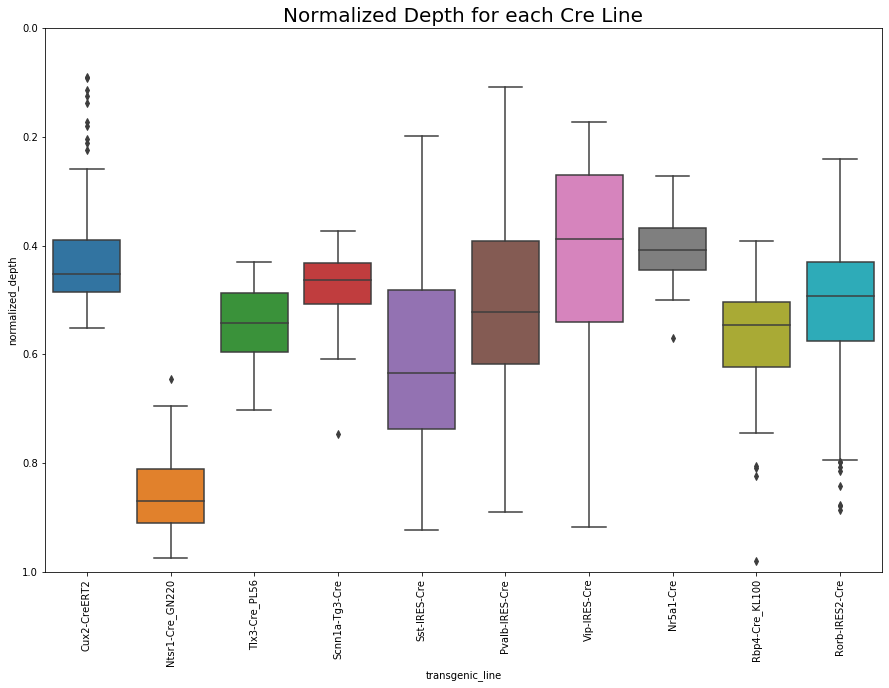

In [37]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.boxplot(x = 'transgenic_line', y='normalized_depth', data=mouse_df_exps, order=['Cux2-CreERT2',
 'Ntsr1-Cre_GN220',
 'Tlx3-Cre_PL56',
 'Scnn1a-Tg3-Cre',
 'Sst-IRES-Cre',
 'Pvalb-IRES-Cre',
 'Vip-IRES-Cre',
 'Nr5a1-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre'] )

plt.title("Normalized Depth for each Cre Line", fontsize = 20)
ax.set_ylim(1.0,0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Figure 1. 
This boxplot graphs the normalized depth for each Cre line, with the data from the Cell Types database. The bottom of the graph represents the deepest layer and the top represents the more superficial layers of cortex. The graph reveals Ntsr1-Cre labels the deepest layer of cortex, compared to the other lines. The Pvalb-IRES-Cre, Sst-IRES-Cre, Rorb-IRES2-Cre, and the Vip-IRES-Cre lines show scattered expression throughout the layers. All of the other lines vary between the middle layers of cortex.

### Graph a Boxplot of the Brain Observatory Data
We will make another boxplot for the imaging depth collected in the Brain Observatory database for each Cre line.

[Text(0, 0, 'Cux2-CreERT2'),
 Text(0, 0, 'Ntsr1-Cre_GN220'),
 Text(0, 0, 'Tlx3-Cre_PL56'),
 Text(0, 0, 'Scnn1a-Tg3-Cre'),
 Text(0, 0, 'Sst-IRES-Cre'),
 Text(0, 0, 'Pvalb-IRES-Cre'),
 Text(0, 0, 'Vip-IRES-Cre'),
 Text(0, 0, 'Nr5a1-Cre'),
 Text(0, 0, 'Rbp4-Cre_KL100'),
 Text(0, 0, 'Rorb-IRES2-Cre')]

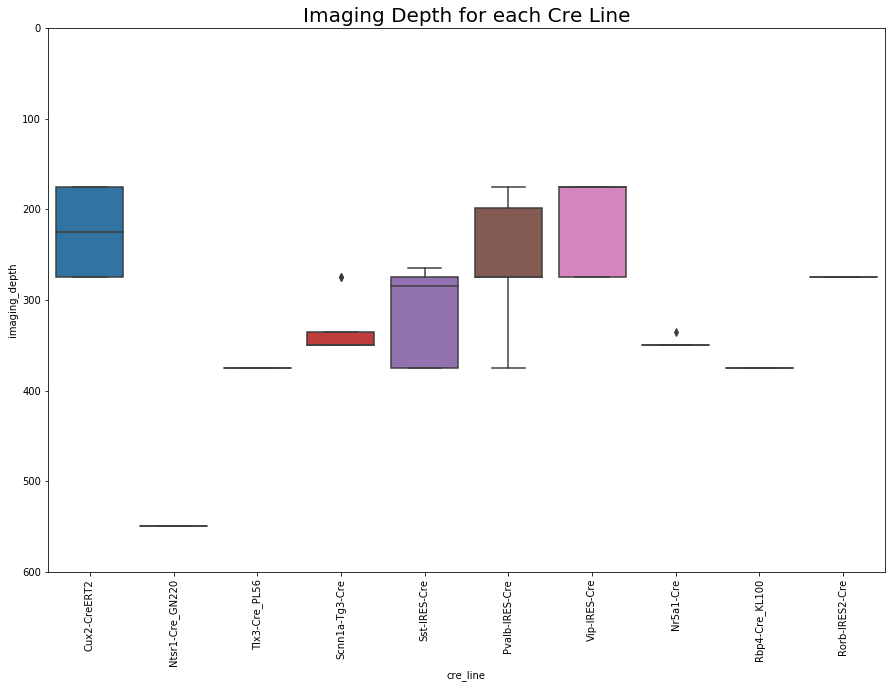

In [71]:
fig,ax = plt.subplots(figsize=(15,10))


ax = sns.boxplot(x='cre_line', y='imaging_depth', data=exps_df, order=['Cux2-CreERT2',
 'Ntsr1-Cre_GN220',
 'Tlx3-Cre_PL56',
 'Scnn1a-Tg3-Cre',
 'Sst-IRES-Cre',
 'Pvalb-IRES-Cre',
 'Vip-IRES-Cre',
 'Nr5a1-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre'] )

plt.title("Imaging Depth for each Cre Line", fontsize = 20)
ax.set_ylim(600,0)


ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

### Figure 2.
This boxplot graphs the imaging depth for each Cre line, with the data from the Brain Observatory database. The bottom of the graph represents the deepest layer and the top represents the more superficial layers of cortex. The graph also reveals that Ntsr1-Cre labels the deepest layer of cortex. In this boxplot, both the Sst-IRES-Cre, Pvalb-IRES-Cre, and Vip-IRES-Cre lines demonstrate the greatest spread of expression across cortex. Interestingly, the Rorb-IRES2-Cre does not demonstrate scattered expression. Rbp4-Cre and Tlx3-Cre both show dense expression in the same layer. Scnn1a-Tg3-Cre and Nr5a1-Cre also both show expression in the same layer, which is slightly more superficial. 

## Part 2: Perform Correlational Analysis on the Depths between the Two Databases

### Determine if the Data is Skewed
We will now run a skewtest on the depth data provided by both databases. If the data is skewed, then we will report the median. If the data is normally distributed, then we will report the mean. 

We will run the skew test on the Cell Types data.

In [65]:
ct_skewtest = mouse_df_exps['normalized_depth']

ct_skewed_stats, ct_skewed = stats.skewtest(ct_skewtest)
if ct_skewed > 0.05:
    print('Normal Distribution')
else:
    print('Skewed Distribution')

Skewed Distribution


We will then run the skew test on the Brain Observatory data.

In [72]:
boc_skewtest = exps_df['imaging_depth']

boc_skewed_stats, boc_skewed = stats.skewtest(boc_skewtest)
if boc_skewed > 0.05:
    print('Normal Distribution')   
else:
    print('Skewed Distribution')

Skewed Distribution


### Determine the Median Depth for each Cre-line
Since both datasets consist of skewed distributions, we will find the median depth for each Cre-line

In [67]:
celltypes_medians = []
for line in overlapping_lines:
    med = mouse_df_exps[mouse_df_exps['transgenic_line'] == line]['normalized_depth'].median()
    celltypes_medians.append(med)

boc_medians = []
for line in overlapping_lines:
    med2 = exps_df[exps_df['cre_line'] == line]['imaging_depth'].median()
    boc_medians.append(med2)
    
print(celltypes_medians)
print(boc_medians)

[0.45185051685577005, 0.5227868586293505, 0.5420492258911205, 0.546854367118561, 0.46336818457228, 0.49184699080218053, 0.387328592630399, 0.408190155407996, 0.634047119763261, 0.870134676511205]
[225.0, 275.0, 375.0, 375.0, 350.0, 275.0, 175.0, 350.0, 285.0, 550.0]


### Plot the Correlation and Determine the Pearson's r
We will now plot the medians across both databases. 

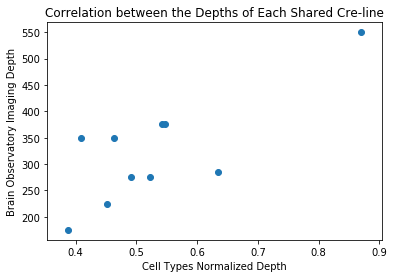

In [76]:
plt.scatter(celltypes_medians, boc_medians)
plt.title('Correlation between the Depths of Each Shared Cre-line')
plt.xlabel('Cell Types Normalized Depth')
plt.ylabel('Brain Observatory Imaging Depth')
plt.show()

### Figure 3. 
This scatterplot reveals the positive correlation between the normalized depth of the Cell Types database and the imaging depth of the Brain Observatory database.

We now calculate the Pearson's r and p-value for both datasets.

In [69]:
pearsons_r , pearsons_p = stats.stats.pearsonr(celltypes_medians, boc_medians)
print("pearson's r: %f    pearson's p: %f" % (pearsons_r, pearsons_p))

pearson's r: 0.778317    pearson's p: 0.008007


The Pearson's r reveals a strong, positive correlation between the depths of both databases, at .78. This is a significant correlation because the p-value is below 0.05.

## Part 3: Perform PCA Analysis for the Cell Types Data


### Generate a Scree Plot for the Cell Types Data
Here we are generating a Scree plot to determine the number of components we should use for the PCA Analysis.

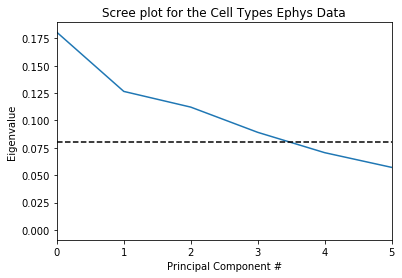

In [78]:
# Create a PCA model
pca = PCA()
data_pca = pca.fit_transform(ephys_norm)
#Here we plot out the data
plt.plot(pca.explained_variance_ratio_) # Plot the expected variance as a function of the PC
plt.axhline(.08,c='k',ls='--') # Plot a horizontal line at 1, the Kaiser criterion

plt.title('Scree plot for the Cell Types Ephys Data')
plt.ylabel('Eigenvalue') 
plt.xlabel('Principal Component #')
plt.xlim(0,5)
plt.show()

### Figure 4. 
Based off the elbow method for the Scree plot, we determined that we should include 4 components in our PCA analysis. We decided this by determining where our plot crosses the dotted line. We set the dotted line at 1, which is the Kaiser criterion. Since the line crosses around 3.5, we decided to include 4 components.

### Perform PCA Clustering Analysis on the Cell Types Data
We will now conduct the PCA analysis on our Cell Types Ephys Normalized data, with 4 components.

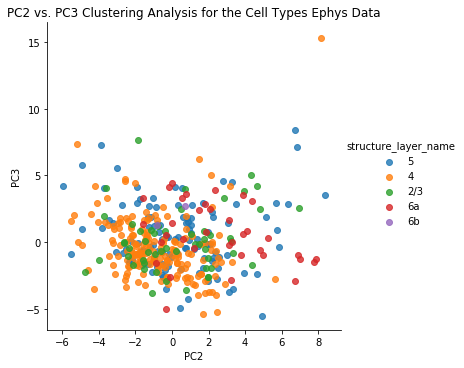

In [80]:
#Create PCA model
pca = PCA(n_components = 4)    
#fit data to 2d model
ephys_2D = pca.fit_transform(ephys_norm) 

ephys_subset['PC1'] = ephys_2D[:, 0]
ephys_subset['PC2'] = ephys_2D[:, 1]
ephys_subset['PC3'] = ephys_2D[:, 2]
ephys_subset['PC4'] = ephys_2D[:, 3]

ephys_subset['structure_layer_name'] = mouse_ephys_df['structure_layer_name']

sns.lmplot("PC2", "PC3", hue='structure_layer_name', data=ephys_subset, fit_reg=False)
plt.title('PC2 vs. PC3 Clustering Analysis for the Cell Types Ephys Data')
plt.show()

### Figure 5. 
After running the PCA analysis on various PC combinations, we decided to graph PC2 vs. PC3. This graph best reveals the clustering of layer 4 (orange), compared to the other layers. Overall, we do not see prominent clustering of the layers based off of the electrophysiology data. We did notice that Layer 4 tended to cluster closer together. 

### Perform PCA Analysis for Layer 4 vs. all the Other Layers
Since we noticed that Layer 4 tended to cluster closer together, we decided to perform a PCA analysis of Layer 4 compared to all of the other layers. 

In [24]:
#We first have to make a separate data frame inorder to save the data without effecting our first pca plot
ephys_subset_grouped = ephys_subset

Here we are grouping all of the layers besides Layer 4. If the value in the layer columns consists of any layer besides Layer 4, we assign the data to  grouped_layers. If the value consists of Layer 4, then we assign the data to layer_four

In [25]:
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '1' , 'layer'] = 'grouped_layers'
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '2/3' , 'layer'] = 'grouped_layers'
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '5' , 'layer'] = 'grouped_layers'
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '6a' , 'layer'] = 'grouped_layers'
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '6b' , 'layer'] = 'grouped_layers'
ephys_subset_grouped.loc[ephys_subset.structure_layer_name == '4', 'layer'] = 'layer_four'

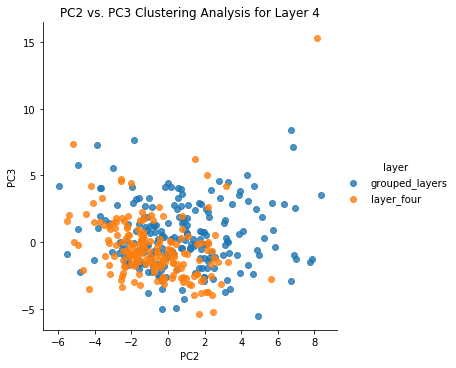

In [84]:
sns.lmplot("PC2", "PC3", hue='layer', data=ephys_subset_grouped, fit_reg=False)
plt.title('PC2 vs. PC3 Clustering Analysis for Layer 4')
plt.show()

### Figure 6.
Our clustering analysis reveals that Layer 4 tends to cluster closer together. But, Layer 4 does not cluster exclusively from the other layers. All of the layers are clustered into one cluster, since both the blue and orange dots are intermingled.  

## Part 4: Perform PCA Analysis for the Brain Observatory Data

### Generate a Scree Plot for the Brain Observatory
Here we are generating a Scree plot to determine the number of components we should use for the PCA Analysis.

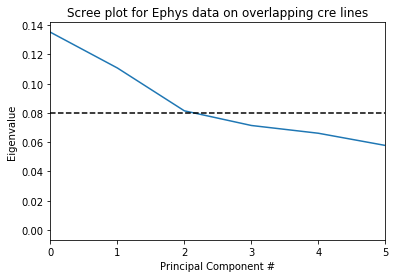

In [85]:
# Create a PCA model
pca = PCA()
data_pca = pca.fit_transform(boc_norm)
#Here we plot out the data
plt.plot(pca.explained_variance_ratio_) # Plot the expected variance as a function of the PC
plt.axhline(.08,c='k',ls='--') # Plot a horizontal line at 1, the Kaiser criterion

plt.title('Scree plot for Ephys data on overlapping cre lines')
plt.ylabel('Eigenvalue') 
plt.xlabel('Principal Component #')
plt.xlim(0,5)
plt.show()

### Figure 7. 
Based off the elbow method for the Scree plot, we determined that we should include 2 components in our PCA analysis. We decided this by determining where our plot crosses the dotted line. We set the dotted line at 1, which is the Kaiser criterion, and the line crosses at 2.

### Perform PCA Clustering Analysis on the Brain Observatory Data
We will now conduct the PCA analysis on the Brain Observatory Normalized data, with 2 components.

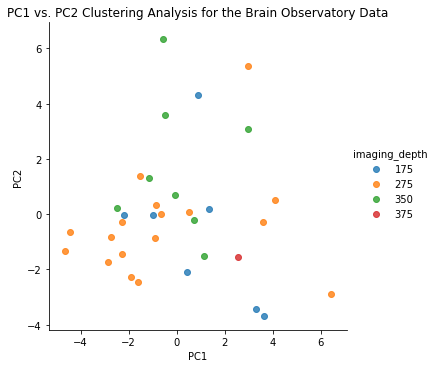

In [86]:
#Create PCA model
pca = PCA(n_components = 2) 
#fit data to 2d model
boc_2D = pca.fit_transform(boc_norm) 
boc_2D

boc_subset['PC1'] = boc_2D[:, 0]
boc_subset['PC2'] = boc_2D[:, 1]

sns.lmplot("PC1", "PC2", hue='imaging_depth', data=boc_subset, fit_reg=False)
plt.title('PC1 vs. PC2 Clustering Analysis for the Brain Observatory Data')
plt.show()

### Figure 8. 
Since the Brain Observatory database does not include many datapoints, our graph does not result in dense clustering. Yet, we can still see that the layers do not cluster into distinct clusters but instead display scattered clustering.

# Conclusion & Discussion